# Analyze the feedback from Product Dev survey

This analysis will apply an unsupervised word embedding `fasttext` along with `K means` to the feedback received from the product development survey to generate a set of topics based on that feedback. 

We will analyze the text from each question distinctly and will generate topics for each question

I completed this analysis with help from the following places:
- https://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/
- https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/
- https://fasttext.cc/docs/en/supervised-tutorial.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- http://benalexkeen.com/k-means-clustering-in-python/
- https://stackoverflow.com/questions/54939424/plotting-vectorized-text-documents-in-matplotlib
- https://fasttext.cc/docs/en/python-module.html#more-examples
- https://austingwalters.com/fasttext-for-sentence-classification/
- https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

Some caveats:
    - I have experience working with ML, but I am not an expert at ML; I am great at google search though
    - I am not an engineer; I learned how to Python through stackexchange and trial-and-error
    - I did this to apply rigor to understanding the patterns and topics in our feedback
    - I have shared this analysis with product/eng leadership

contact @bradley on #slack

### Setting up the environment

<img src="https://media.giphy.com/media/RN96CaqhRoRHk4DlLV/giphy.gif" width="150">

I am using [Anaconda](https://www.anaconda.com/) and [Jupyter Notebook](https://jupyter.org/install) for this analysis. 

Set up `fasttext` following the instructions included [here](https://fasttext.cc/docs/en/support.html); do not try any alternative setups it will only lead to pain and anguish.

```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ sudo pip install .
```

### Imports

In [686]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Files

In [314]:
word_embeddings = '/Users/bradley.webb/Downloads/wiki-news-300d-1M-subword.vec'
abbr_word_embeddings = '/Users/bradley.webb/fastText/fil9'
prod_dev_results = '/Users/bradley.webb/Downloads/Product Development Survey (2019) (Public) - Form Responses 1.csv'

### Data cleaning and preparation

In [315]:
df = pd.read_csv(prod_dev_results)

Responses with line breaks imply multiple thoughts, we can create two different vectors one where we do nothing different `V` and another where we create seperate rows for when a newline occurs `altV`. 

`def paragraph_to_sentence` transforms any text with a newline `\n` into multiple sentences

In [80]:
def paragraph_to_sentence(text):
    new_list = []
    for item in text:
        for next_item in item:
            if next_item:
                new_list.append(next_item.split())
    return new_list

Since we are using both Pandas and Numpy we need to handle any `NAN` entry the two libraries have inconsistent handling of the `NAN` type.

We'll replace `NAN` with an empty string, then ignore empty strings when we process our data

In [650]:
def clean_df(df):
    return df.fillna('').str.split('\n').values

In [627]:
q_going_well = df['What is going well in product development?'].fillna('').str.split('\n').values

In [667]:
q_going_well_list = paragraph_to_sentence(q_going_well)

### Word embedding model

We'll train our model on a corpus of 1 million word vectors trained with subword infomation on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).

See more here: https://fasttext.cc/docs/en/english-vectors.html

In [227]:
ft_model = fasttext.train_unsupervised(word_embeddings, 'skipgram')

In [244]:
simple_model = fasttext.train_unsupervised(abbr_word_embeddings)

Training the `fasttext` model locally takes an hour. Let's save the model here, so we can re-use it rather than retraining it.

In [235]:
ft_model.save_model("wiki_news.bin")

In [246]:
simple_model.save_model("wik9.bin")

We can reload the model later using:

```
ft_model = fasttext.load_model('wiki_news.bin')
or
simple_model = fasttext.load_model('wik9.bin')
```

### Transform our data

In order to understand the text we have we need to transform text strings, in this case as sentences, into numeric vectors that our clustering model can subsequently interpret

We do this using the built-in vectorization functions in **fasttext** `model.get_sentence_vector`. The result is a `np.array` that we can use in our **KMeans** clustering model.

In [654]:
def vectorize_sentence(sentences, model):
    vectors = []
    for sentence in sentences:
        vectors.append(model.get_sentence_vector(sentence[0]))
    return pd.DataFrame(vectors)

In [628]:
V = vectorize_sentence(q_going_well, simple_model)

In [399]:
altV = vectorize_sentence(q_going_well_list, simple_model)

### KMeans Clustering

KMeans is a categorization/clustering model which (at it's most basic) identifies a **centroid** which minimizes the error between that point and the other points in the cluster. **Centroids** are identified through a process of iterative learning (better known as guess and check `¯\_(ツ)_/¯` ).

In order to not overfit our data we have to identify the appropriate number of clusters.

We use an approach titled the **Elbow Method** for optimizing the appropriate number of clusters in the model. This method allows us to identify where the error is minimized.

We'll create a function to allow us to experiment more easily 

In [629]:
def generate_elbow(vectors, maxK=10):
    distortions = [] 
    inertias = [] 
    mapping1 = {} 
    mapping2 = {} 
    K = range(1,maxK)

    for k in K: 
        #Building and fitting the model 
        kmeans = KMeans(n_clusters=k).fit(vectors.values) 
        kmeans.fit(vectors.values)     

        distortions.append(sum(np.min(cdist(vectors.values, kmeans.cluster_centers_, 
                          'euclidean'),axis=1)) / vectors.shape[0]) 
        inertias.append(kmeans.inertia_) 

        mapping1[k] = sum(np.min(cdist(vectors.values, kmeans.cluster_centers_, 
                     'euclidean'),axis=1)) / vectors.shape[0]
        mapping2[k] = kmeans.inertia_
        
    return K, distortions, inertias

In [630]:
K, distortions, inertias = generate_elbow(V)

We can use some calculus (2nd derivative) to identify the ideal number of clusters, but implementing that in Python is a bit of a mess so we are just going to rely on our eyeballs to identify the elbow in the graphs below.

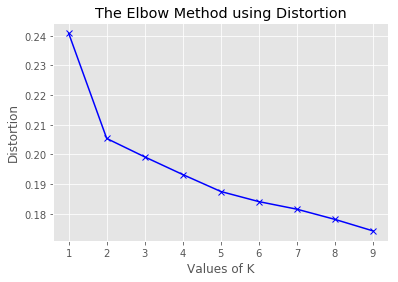

In [631]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

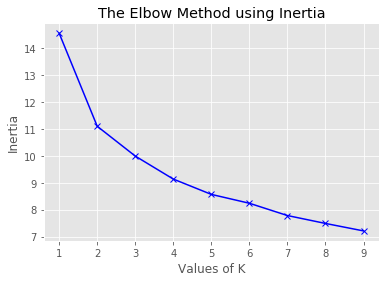

In [632]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [651]:
def plot_elbow(K, mappings, ylabel):
    plt.plot(K, mappings, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('{}'.format(ylabel)) 
    plt.title('The Elbow Method using {}'.format(ylabel)) 
    plt.show()

The elbow in the above graphs clearly happens at the second cluster.

In [619]:
cluster_count = 3

With that we have all the information we need to output the finalized KMean clusters. 

Creating a function makes it easy to experiment with alternative cluster sizes and vectors. 

In [633]:
def final_kmean(vectors, cluster_count):
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(vectors.values)
    
    labels = kmeans.predict(vectors.values)
    centroids = kmeans.cluster_centers_
    
    # https://stackoverflow.com/questions/42583995/\
    # get-the-centroid-row-index-from-k-means-clustering-using-sklearn 
    min_dist = np.min(cdist(vectors.values, kmeans.cluster_centers_, 'euclidean'), axis=1)
    
    Y = pd.DataFrame(min_dist, index=vectors.index, columns=['Center_euclidean_dist'])
    Z = pd.DataFrame(labels, index=vectors.index, columns=['cluster_ID'])
    PAP = pd.concat([Y,Z], axis=1)
    grouped = PAP.groupby(['cluster_ID'])
    
    cluster_index = grouped.idxmin()
    
    return kmeans, labels, centroids, cluster_index

In [634]:
kmeans, labels, centroids, cluster_index = final_kmean(V, cluster_count)

### Reduce dimmensionality and graph

We'll use PCA to reduce the dimmensionality of our vectors into 2 dimmensions so we can graph them on a scatter plot and we'll use `matplotlib` to plot the scatter so we can visually inspect our cluster to ensure they make sense. 

In [635]:
# We train the PCA on the dense version of the vector. 
pca = PCA(n_components=2)
two_dim = pca.fit_transform(V.values)

scatter_x = two_dim[:, 0] # first principle component
scatter_y = two_dim[:, 1] # second principle component

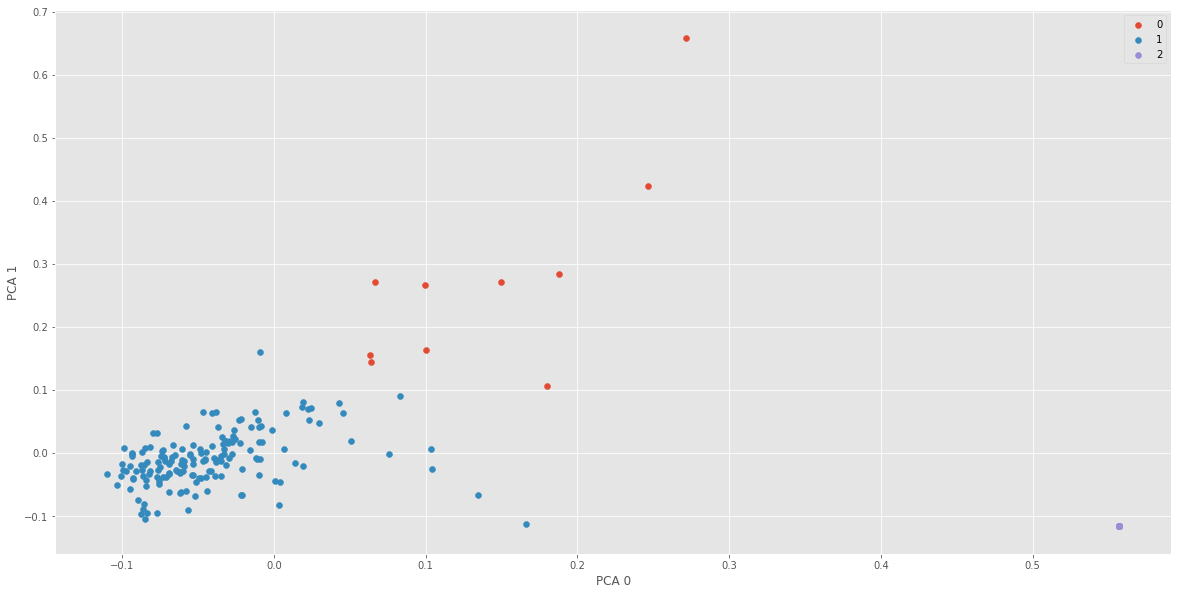

In [636]:
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

colors = {}
for c in range(cluster_count):
    colors[c] = 'C{}'.format(c)

for group in np.unique(labels):
    ix = np.where(labels == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=colors[group], label=group)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()

The graph shows the two distinct clusters, in this case where cluster `0` has the preponderance of data and cluster `1` has a single member. 

### Topics

Using the centroids we identified in our final KMeans model we can use the **fasttext** model to return the most topics of the centroid. 

Essentially what we are doing is assuming that the centroid is a good representation of the rest of the data in that cluster, therefore the topics represented by the centroid should do a good job representing the rest of the cluster.

In our `final_kmean` method above we define the index of the centroids. From that index we will create a list of the topics. 

In [637]:
cluster_index

,Center_euclidean_dist
cluster_ID,
0,107
1,49
2,33


In [638]:
topics = []
for cent in range(cluster_count):
    dfidx = cluster_index['Center_euclidean_dist'][cent]
    topics.append([simple_model.get_nearest_neighbors(word) for word in q_going_well[dfidx][0].split()])

In [647]:
topic_df = pd.DataFrame()
for row in range(len(topics)):
    for i, x in enumerate(topics[row]):
        if x:
            if topic_df.empty:
                topic_df = pd.DataFrame([topic for topic in x], columns=['score', 'topic'])
                topic_df['cluster_ID'] = row
            else:
                topic_df_2 = pd.DataFrame([topic for topic in x], columns=['score', 'topic'])
                topic_df_2['cluster_ID'] = row
                topic_df = topic_df.append(topic_df_2, ignore_index=True)

topic_df.iloc[topic_df.reset_index().groupby(['cluster_ID']).score.nlargest(10).index.levels[1]]
# topic_df.groupby(['cluster_ID']).score.nlargest(10).index.levels[0]
# topic_df.sort_values(by='score', ascending=False).loc[topic_df['score'] >= .9]

,score,topic,cluster_ID
20,0.862004,the,0
40,0.906627,focusing,0
70,0.896215,intercommunication,0
71,0.895745,communicating,0
72,0.889420,communicative,0
90,0.908075,ngineering,0
91,0.874261,bioengineering,0
92,0.870609,reengineering,0
130,0.898095,directors,0
170,0.925991,excellent,0


Here are the 10 topics associated with our cluster

### Analyzing the full Product Dev dataset

Let's expand our analysis to the remaining columns in the Product Dev dataset

In [641]:
[col for col in df.columns]

['Timestamp',
 'What is going well in product development?',
 'What is not going well in product development?',
 'What is one thing you want to be true about who we are as a product development organization by the end of 2020?',
 'Why is this important to you?',
 'How likely is it that you would recommend a friend or colleague join our product development organization?',
 'Why did you choose this score?',
 'What is your role? (NOT REQUIRED)',
 'What college are you in? (NOT REQUIRED)',
 'Do you want to keep your response private rather than sharing with the APM development team? (Please considering sharing it as it allows everyone to benefit from your response!)']

What is going well in product development?


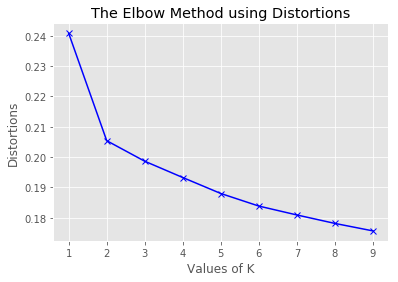

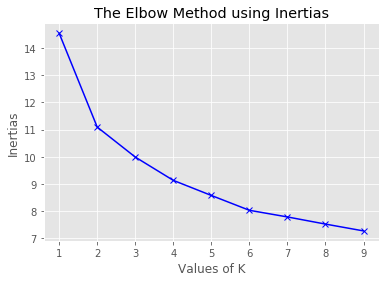

What is not going well in product development?


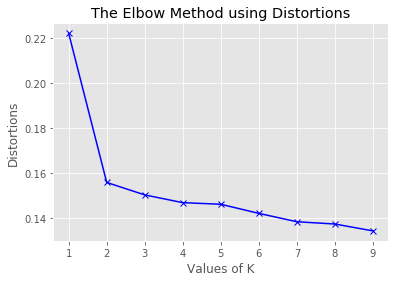

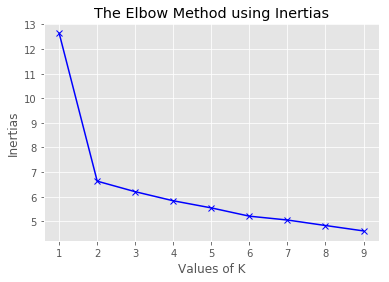

What is one thing you want to be true about who we are as a product development organization by the end of 2020?


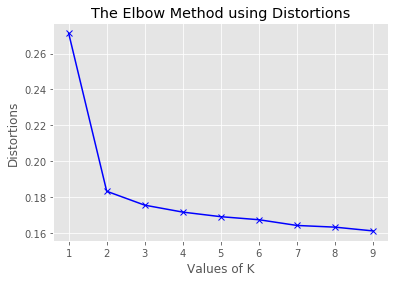

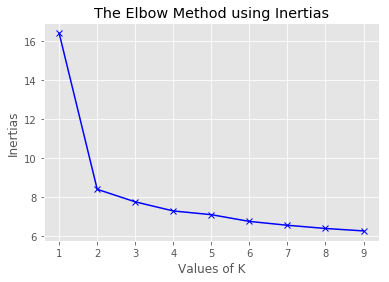

Why is this important to you?


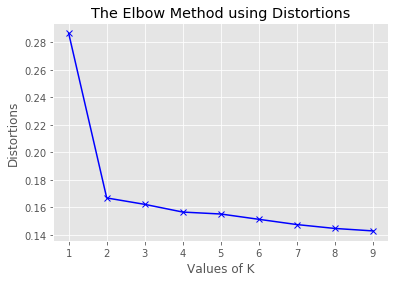

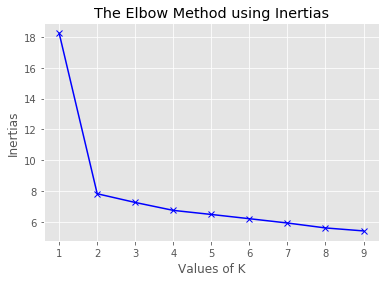

Why did you choose this score?


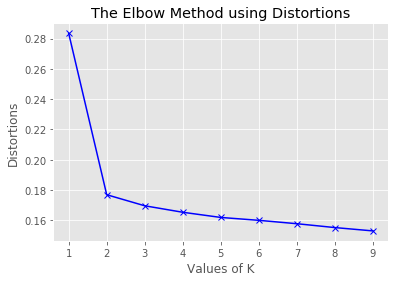

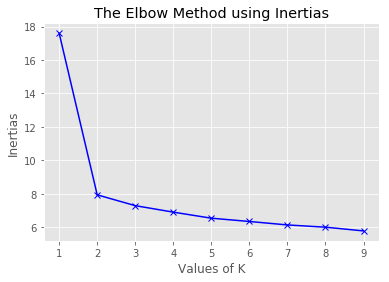

In [657]:
column_targets = [
    'What is going well in product development?',
    'What is not going well in product development?',
    'What is one thing you want to be true about who we are as a product development organization by the end of 2020?',
    'Why is this important to you?',
    'Why did you choose this score?'
]

for col in column_targets:
    sentences = clean_df(df[col])
    vectors = vectorize_sentence(sentences , simple_model)
    K, distortions, inertias = generate_elbow(vectors)
    print(col)
    plot_elbow(K, distortions, 'Distortions')
    plot_elbow(K, inertias, 'Inertias')

The elbow for all the datasets is at 2.

Given that the dataset isn't large and the answers had strong similarities that might make sense. Better normalization and preprocessing might tease out more nuance in the clusters.

We'll leave that for follow-on investigation.

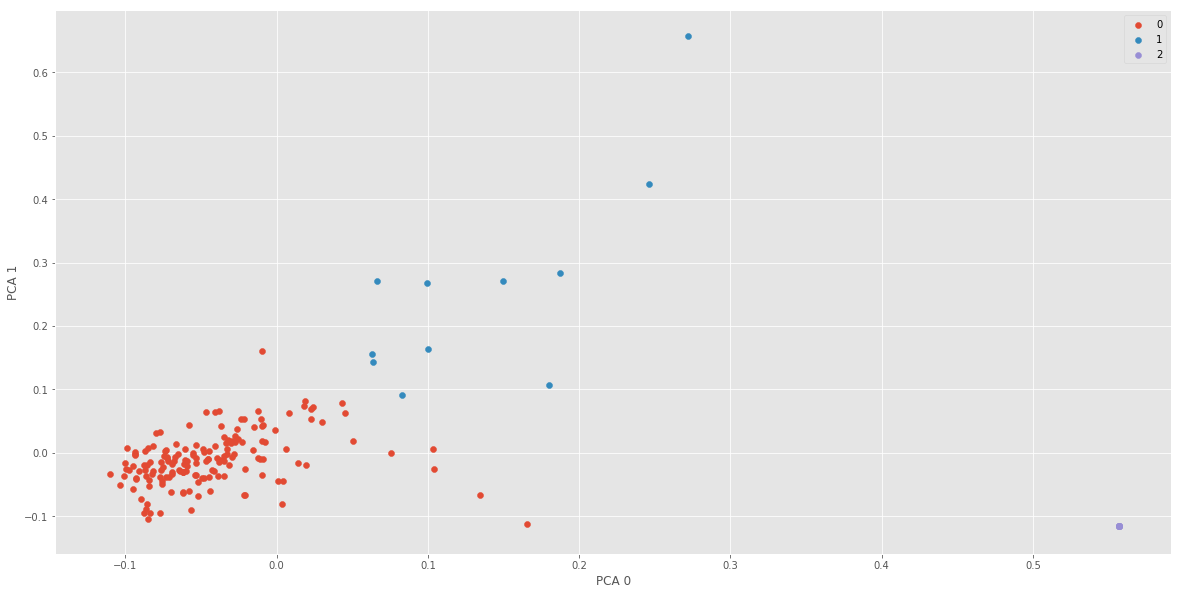

         score               topic  cluster_ID
190   0.935157            learning           0
590   0.916157                some           0
630   0.916157                some           0
650   0.948401         departments           0
651   0.926802        departmental           0
790   0.927769              though           0
810   0.955872       conversations           0
811   0.937497        conversation           0
812   0.914463      conversational           0
920   0.928519            instance           0
970   0.862004                 the           1
990   0.906627            focusing           1
1020  0.896215  intercommunication           1
1021  0.895745       communicating           1
1022  0.889420       communicative           1
1040  0.908075          ngineering           1
1041  0.874261      bioengineering           1
1042  0.870609       reengineering           1
1080  0.898095           directors           1
1120  0.925991           excellent           1


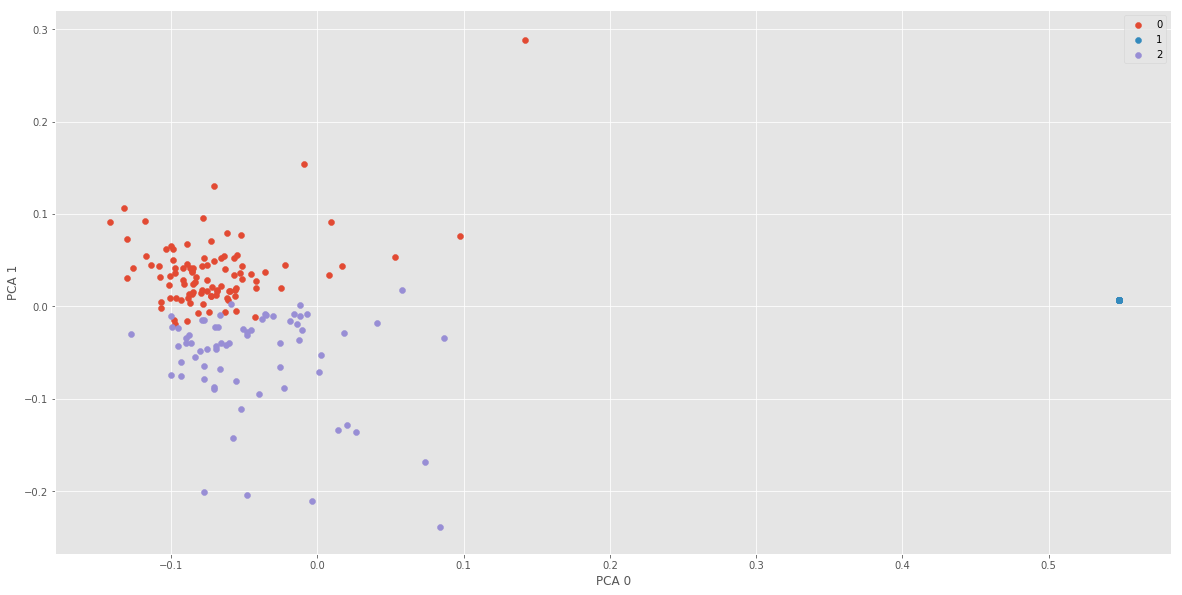

        score         topic  cluster_ID
150  0.908788        cranks           0
151  0.889523      crankpin           0
220  0.886317      actually           0
250  0.887232      customer           0
370  0.906072   playfulness           0
371  0.899797  cheerfulness           0
372  0.879894  youthfulness           0
430  0.886317      actually           0
530  0.961228  particularly           0
590  0.910648        topics           0
600  0.886263         eople           1
620  0.853580    unfriendly           1
621  0.842274    friendlier           1
630  0.852083            in           1
640  0.857477     unwilling           1
680  0.828543          some           1
681  0.826051         these           1
682  0.823709     including           1
700  0.823858          give           1
720  0.835726         moves           1
760  0.839589        worked           2
810  0.878310           you           2
811  0.836401        wouldn           2
812  0.823189          wish           2


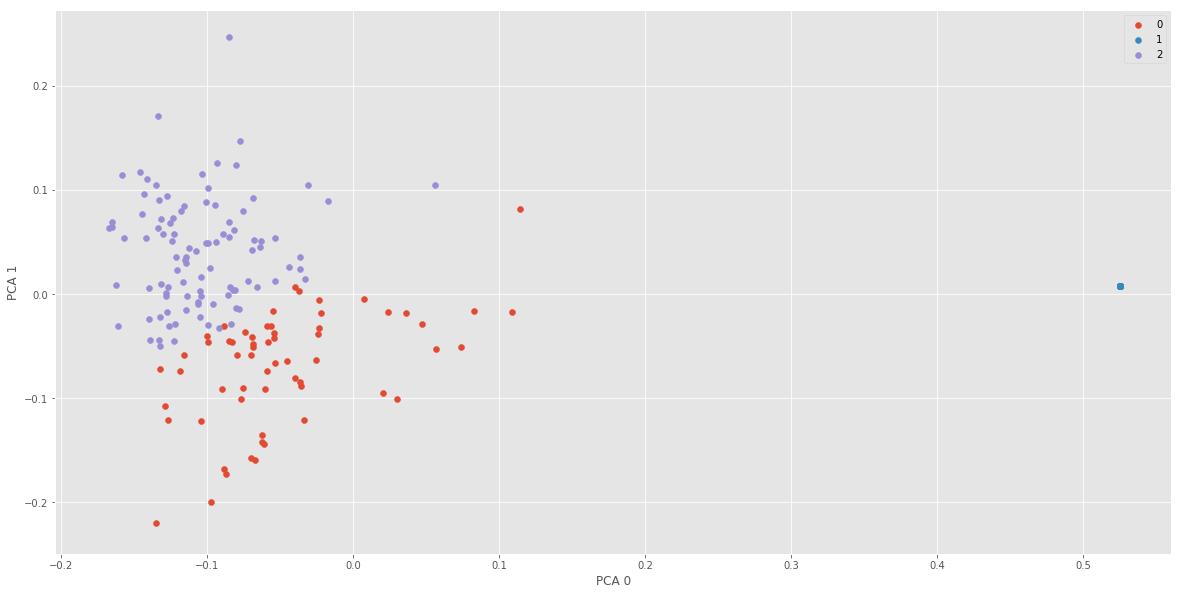

        score           topic  cluster_ID
0    0.906188        teamwork           1
1    0.808492      steamworks           1
2    0.792114      dreamworks           1
3    0.733013       dreamword           1
4    0.678683      dreamworld           1
5    0.616106         synergy           1
6    0.612150        formwork           1
7    0.599106             skg           1
8    0.589115     edutainment           1
9    0.580597       filmworks           1
40   0.862004              in           2
50   0.892989        colleges           2
190  0.889561           being           2
220  0.949542  understandings           2
330  0.862004              in           2
340  0.872029         impacts           2
460  0.863640       providing           2
480  0.901003            less           2
481  0.889880            than           2
490  0.896508     confidences           2


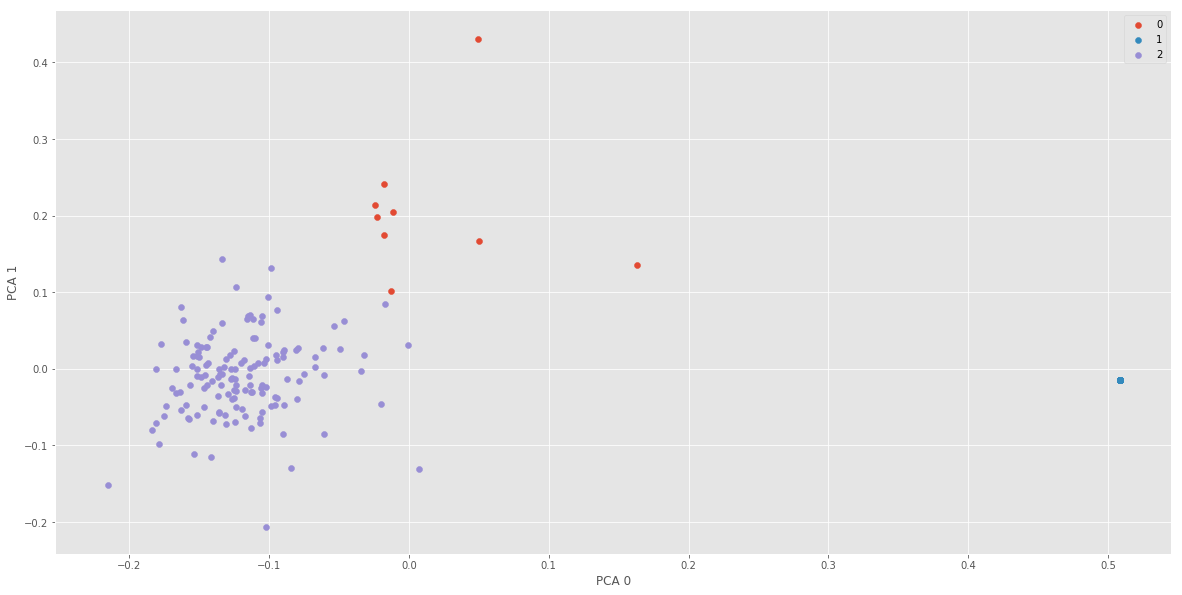

        score        topic  cluster_ID
0    0.886263        eople           0
50   0.865178     crunches           0
70   0.919168    deadlines           0
71   0.873078     deadline           0
100  0.856289  essentially           0
140  0.875978      culture           0
180  0.862004           in           0
240  0.857645       unless           0
250  0.855475           or           0
280  0.892301     changeup           0
290  0.906188     teamwork           1
291  0.808492   steamworks           1
292  0.792114   dreamworks           1
293  0.733013    dreamword           1
294  0.678683   dreamworld           1
295  0.616106      synergy           1
296  0.612150     formwork           1
297  0.599106          skg           1
298  0.589115  edutainment           1
299  0.580597    filmworks           1
310  0.846717          the           2
320  0.834794       trusts           2
340  0.852083           in           2
360  0.925751     negative           2
361  0.853815    negative

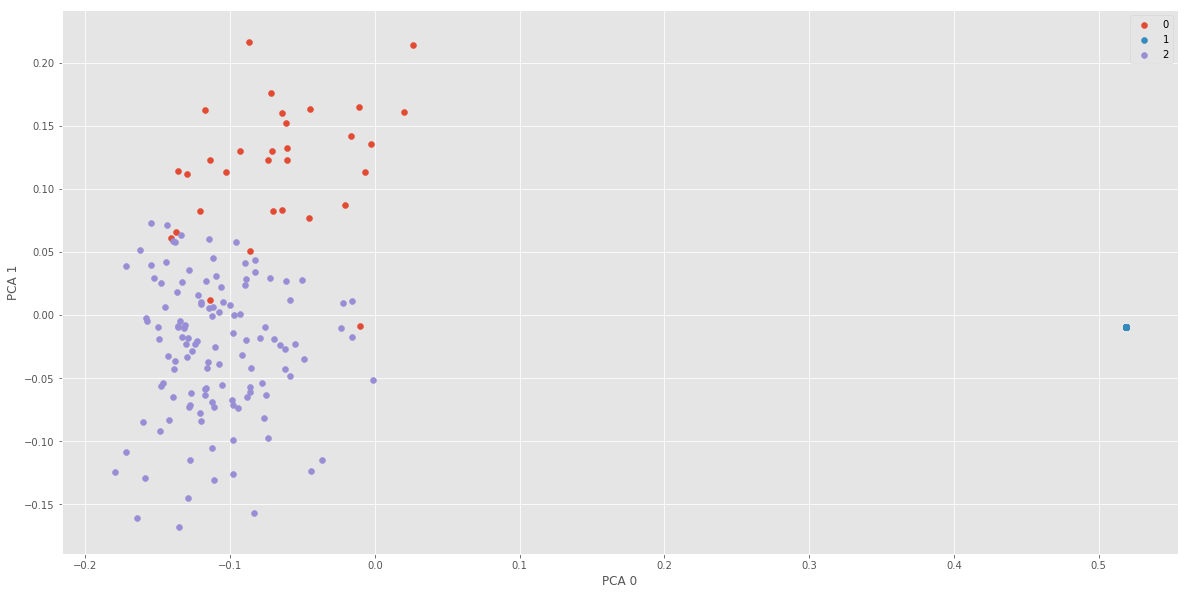

        score        topic  cluster_ID
10   0.846717          the           0
20   0.834794       trusts           0
40   0.852083           in           0
60   0.925751     negative           0
61   0.853815    negatived           0
70   0.852590  corporation           0
90   0.852083           in           0
100  0.867555    direction           0
101  0.859312  directional           0
102  0.855474   directions           0
110  0.906188     teamwork           1
111  0.808492   steamworks           1
112  0.792114   dreamworks           1
113  0.733013    dreamword           1
114  0.678683   dreamworld           1
115  0.616106      synergy           1
116  0.612150     formwork           1
117  0.599106          skg           1
118  0.589115  edutainment           1
119  0.580597    filmworks           1
260  0.963206        seven           2
261  0.956898        eight           2
262  0.943386         nine           2
263  0.935212        three           2
264  0.934880         fou

In [693]:
cluster_count = 3

for col in column_targets:
    sentences = clean_df(df[col])
    vectors = vectorize_sentence(sentences , simple_model)
    kmeans, labels, centroids, cluster_index = final_kmean(vectors, cluster_count)
    pca = PCA(n_components=2)
    two_dim = pca.fit_transform(vectors.values)

    scatter_x = two_dim[:, 0] # first principle component
    scatter_y = two_dim[:, 1] # second principle component

    plt.style.use('ggplot')

    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)

    colors = {}
    for c in range(cluster_count):
        colors[c] = 'C{}'.format(c)

    for group in np.unique(labels):
        ix = np.where(labels == group)
        ax.scatter(scatter_x[ix], scatter_y[ix], c=colors[group], label=group)

    ax.legend()
    plt.xlabel("PCA 0")
    plt.ylabel("PCA 1")
    plt.show()

    topics = []
    for cent in range(cluster_count):
        dfidx = cluster_index['Center_euclidean_dist'][cent]
        topics.append([simple_model.get_nearest_neighbors(word) for word in q_going_well[dfidx][0].split()])

    topic_df = pd.DataFrame()
    for row in range(len(topics)):
        for i, x in enumerate(topics[row]):
            if x:
                if topic_df.empty:
                    topic_df = pd.DataFrame([topic for topic in x], columns=['score', 'topic'])
                    topic_df['cluster_ID'] = row
                else:
                    topic_df_2 = pd.DataFrame([topic for topic in x], columns=['score', 'topic'])
                    topic_df_2['cluster_ID'] = row
                    topic_df = topic_df.append(topic_df_2, ignore_index=True)

    print(topic_df.iloc[topic_df.reset_index().groupby(['cluster_ID']).score.nlargest(10).index.levels[1]])

Thanks for reading!

### Appendix --- I tried TF-IDF too!

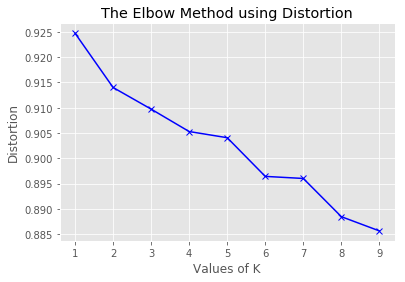

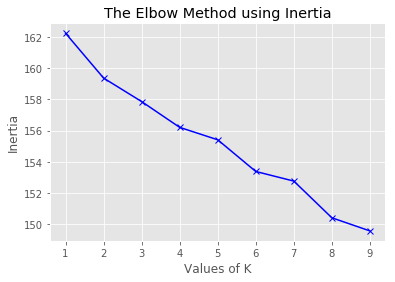

In [688]:
"""
- https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
"""

from sklearn.feature_extraction.text import TfidfVectorizer

tf_sent = [sent[0].strip() for sent in q_going_well]

tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(tf_sent)
# km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1,
#                 verbose=False)
# km.fit(X)

# def generate_elbow(vectors, maxK=10):
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)

for k in K: 
    #Building and fitting the model 
    kmeans = KMeans(n_clusters=k).fit(X) 
    kmeans.fit(X)     

    distortions.append(sum(np.min(cdist(X.toarray(), kmeans.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeans.inertia_) 

    mapping1[k] = sum(np.min(cdist(X.toarray(), kmeans.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0]
    mapping2[k] = kmeans.inertia_
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

# return K, distortions, inertias

<h2><center>That's it folks!</center></h2>

![see ya](https://media.giphy.com/media/3ohs7KViF6rA4aan5u/giphy.gif)